<a href="https://colab.research.google.com/github/derrionrobinson/Machine-Learning-Practice/blob/main/Homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import time
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Epoch 20, Train Loss: 0.7136, Test Loss: 0.7201
Epoch 40, Train Loss: 0.6942, Test Loss: 0.6950
Epoch 60, Train Loss: 0.6754, Test Loss: 0.6711
Epoch 80, Train Loss: 0.6545, Test Loss: 0.6454
Epoch 100, Train Loss: 0.6268, Test Loss: 0.6128
Epoch 120, Train Loss: 0.5946, Test Loss: 0.5762
Epoch 140, Tr

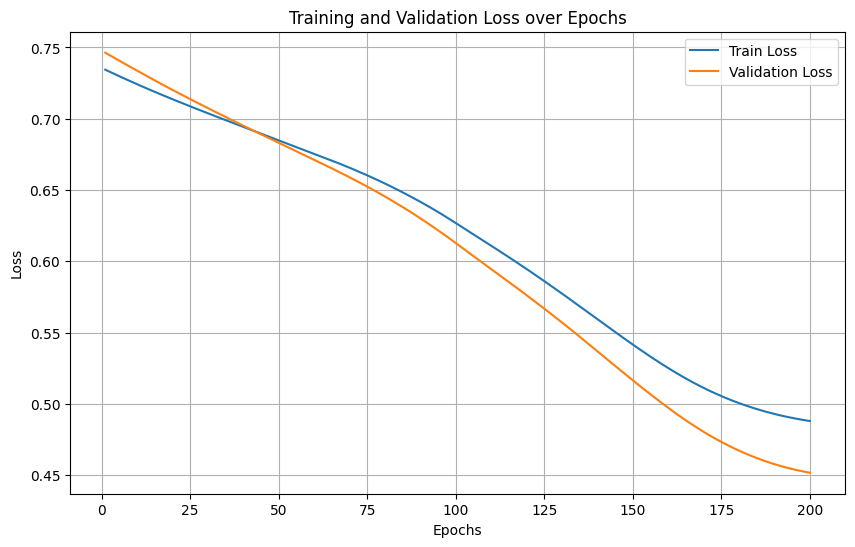

In [23]:
#Problem 1 Solution

url = 'https://raw.githubusercontent.com/derrionrobinson/Machine-Learning-Practice/refs/heads/main/diabetes.csv'
diabetes = pd.read_csv(url)
print(diabetes.head())

# Strong predictors
top_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']
X = diabetes[top_features]
y = diabetes['Outcome']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0
)

#Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Convert labels to numpy and correct shape (N,1)
y_train = y_train.values.reshape(-1, 1)
y_test  = y_test.values.reshape(-1, 1)

#Tensor Conversion
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

#Neural Network
input_dim = X_train_tensor.shape[1]
hidden_dim = 8
output_dim = 1

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),

    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),

    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),

    nn.Linear(hidden_dim, output_dim)
)

#Function Loss and Optiizer
LossFunction = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Loop
n_epochs = 200
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(1, n_epochs + 1):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = LossFunction(outputs, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = LossFunction(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    # Every 20 epochs print
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = LossFunction(test_outputs, y_test_tensor).item()

        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

end_time = time.time()
print(f"\nTraining Time: {end_time - start_time:.2f} seconds\n")

#Evaluation
model.eval()
with torch.no_grad():
    # Probability Conversions
    train_probs = torch.sigmoid(model(X_train_tensor))
    test_probs  = torch.sigmoid(model(X_test_tensor))

    # Probability Conversions to binary
    train_preds = (train_probs > 0.5).float()
    test_preds  = (test_probs > 0.5).float()

    # Accuracy
    train_accuracy = (train_preds.eq(y_train_tensor).sum().item()) / len(y_train_tensor)
    test_accuracy  = (test_preds.eq(y_test_tensor).sum().item()) / len(y_test_tensor)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy:  {test_accuracy:.4f}")

#Metrics
tp = ((test_preds == 1) & (y_test_tensor == 1)).sum().item()
tn = ((test_preds == 0) & (y_test_tensor == 0)).sum().item()
fp = ((test_preds == 1) & (y_test_tensor == 0)).sum().item()
fn = ((test_preds == 0) & (y_test_tensor == 1)).sum().item()

precision = tp / (tp + fp + 1e-8)
recall    = tp / (tp + fn + 1e-8)
f1        = 2 * (precision * recall) / (precision + recall + 1e-8)

print("\n--- Classification Metrics ---")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

#Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-1870347909.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset_df['ground_truth'].replace(0, 'Benign', inplace=True)


Epoch 20, Train Loss: 0.6633, Test Loss: 0.6479
Epoch 40, Train Loss: 0.6575, Test Loss: 0.6388
Epoch 60, Train Loss: 0.6500, Test Loss: 0.6274
Epoch 80, Train Loss: 0.6387, Test Loss: 0.6116
Epoch 100, Train Loss: 0.6193, Test Loss: 0.5869
Epoch 120, Train Loss: 0.5919, Test Loss: 0.5518
Epoch 140, Train Loss: 0.5629, Test Loss: 0.5146
Epoch 160, Train Loss: 0.5396, Test Loss: 0.4827
Epoch 180, Train Loss: 0.5248, Test Loss: 0.4642
Epoch 200, Train Loss: 0.5143, Test Loss: 0.4540

Training Time: 0.48 seconds

Training Accuracy: 0.7720
Testing Accuracy:  0.8117

--- Classification Metrics ---
Precision: 0.7368
Recall:    0.5957
F1 Score:  0.6588


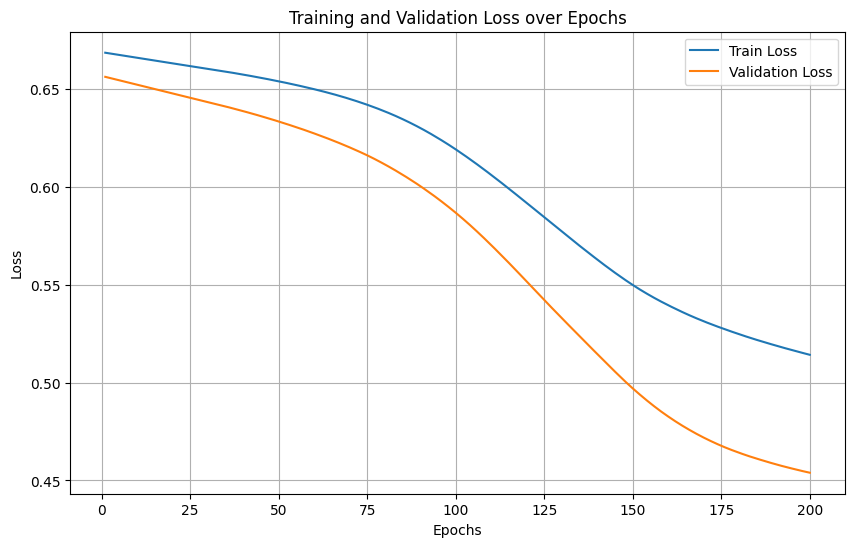

In [20]:
#Problem 2

#Dataset
cancer_data = load_breast_cancer()
feature_values = cancer_data.data
feature_names = cancer_data.feature_names
target_values = cancer_data.target

explanatory_df = pd.DataFrame(feature_values, columns=feature_names)

# Combine features and ground truth
ground_truth = np.reshape(target_values, (569, 1))
combined_data = np.concatenate([feature_values, ground_truth], axis=1)

columns_with_label = np.append(feature_names, 'ground_truth')
dataset_df = pd.DataFrame(combined_data, columns=columns_with_label)

# Replace numeric labels with class names
dataset_df['ground_truth'].replace(0, 'Benign', inplace=True)
dataset_df['ground_truth'].replace(1, 'Malignant', inplace=True)

#Variables
explanatory_variables = explanatory_df.iloc[:, 0:31].values
ground_truth = target_values

# Train/Test Split
explanatory_train, explanatory_test, ground_truth_train, ground_truth_test = train_test_split(
    explanatory_variables, ground_truth, test_size=0.20, random_state=0
)

# Standardization
scaler = StandardScaler()
explanatory_train = scaler.fit_transform(explanatory_train)
explanatory_test = scaler.transform(explanatory_test)

#Tensor Conversion
X_train = torch.tensor(explanatory_train, dtype=torch.float)
X_test = torch.tensor(explanatory_test, dtype=torch.float)

y_train = torch.tensor(ground_truth_train, dtype=torch.float)
y_test = torch.tensor(ground_truth_test, dtype=torch.float)

#Neural Network
input_dim = X_train_tensor.shape[1]
hidden_dim = 8
output_dim = 1

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),

    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),

    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),

    nn.Linear(hidden_dim, output_dim)
)

#Function Loss and Optimizer
LossFunction = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training Loop
n_epochs = 200
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(1, n_epochs + 1):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = LossFunction(outputs, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = LossFunction(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    # Every 20 epochs print
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = LossFunction(test_outputs, y_test_tensor).item()

        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

end_time = time.time()
print(f"\nTraining Time: {end_time - start_time:.2f} seconds\n")

#Evaluation
model.eval()
with torch.no_grad():

    train_probs = torch.sigmoid(model(X_train_tensor))
    test_probs  = torch.sigmoid(model(X_test_tensor))


    train_preds = (train_probs > 0.5).float()
    test_preds  = (test_probs > 0.5).float()

    # Accuracy
    train_accuracy = (train_preds.eq(y_train_tensor).sum().item()) / len(y_train_tensor)
    test_accuracy  = (test_preds.eq(y_test_tensor).sum().item()) / len(y_test_tensor)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy:  {test_accuracy:.4f}")

# Metrics
tp = ((test_preds == 1) & (y_test_tensor == 1)).sum().item()
tn = ((test_preds == 0) & (y_test_tensor == 0)).sum().item()
fp = ((test_preds == 1) & (y_test_tensor == 0)).sum().item()
fn = ((test_preds == 0) & (y_test_tensor == 1)).sum().item()

precision = tp / (tp + fp + 1e-8)
recall    = tp / (tp + fn + 1e-8)
f1        = 2 * (precision * recall) / (precision + recall + 1e-8)

print("\n--- Classification Metrics ---")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

#Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#Problem 3a

#Cifar10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
cifar10_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

cifar10_full = [(img, label) for img, label in cifar10]
cifar10_val_full = [(img, label) for img, label in cifar10_val]

train_loader = torch.utils.data.DataLoader(cifar10_full, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val_full, batch_size=64, shuffle=False)

#Neural Network
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 10),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 10

for epoch in range(n_epochs):
    start_time = time.time()
    running_loss = 0.0

    #Training Loop
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]

        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Validation Accuracy
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)

            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    accuracy = correct / total
    avg_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time

    print("Epoch %d | Time: %.2f sec | Loss: %.4f | Accuracy: %.2f%%" %
          (epoch+1, epoch_time, avg_loss, accuracy * 100))

print("Training complete.")


Epoch 1 | Time: 6.72 sec | Loss: 1.8726 | Accuracy: 38.28%
Epoch 2 | Time: 7.05 sec | Loss: 1.7562 | Accuracy: 40.39%
Epoch 3 | Time: 7.26 sec | Loss: 1.7157 | Accuracy: 41.16%
Epoch 4 | Time: 6.44 sec | Loss: 1.6857 | Accuracy: 41.75%
Epoch 5 | Time: 7.23 sec | Loss: 1.6610 | Accuracy: 42.33%
Epoch 6 | Time: 6.48 sec | Loss: 1.6370 | Accuracy: 42.38%
Epoch 7 | Time: 7.27 sec | Loss: 1.6166 | Accuracy: 43.48%
Epoch 8 | Time: 6.39 sec | Loss: 1.5956 | Accuracy: 43.90%
Epoch 9 | Time: 7.30 sec | Loss: 1.5758 | Accuracy: 44.82%
Epoch 10 | Time: 7.20 sec | Loss: 1.5559 | Accuracy: 44.94%
Training complete.


In [13]:
#Problem 3b

#Cifar10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
cifar10_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)


cifar10_full = [(img, label) for img, label in cifar10]
cifar10_val_full = [(img, label) for img, label in cifar10_val]

train_loader = torch.utils.data.DataLoader(cifar10_full, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val_full, batch_size=64, shuffle=False)

# Extended Neural Network with 3 hidden layers
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
).to(device)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 300

for epoch in range(n_epochs):
    start_time = time.time()
    running_loss = 0.0

    # Training Loop
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.shape[0]

        optimizer.zero_grad()
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            batch_size = imgs.shape[0]

            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)

            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    accuracy = correct / total
    avg_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time

    # Print every 30 epochs
    if (epoch + 1) % 30 == 0 or epoch == 0:
        print("Epoch %d | Time: %.2f sec | Loss: %.4f | Accuracy: %.2f%%" %
              (epoch + 1, epoch_time, avg_loss, accuracy * 100))

print("Training complete.")


Epoch 1 | Time: 1.93 sec | Loss: 1.9988 | Accuracy: 35.23%
Epoch 30 | Time: 1.65 sec | Loss: 1.0373 | Accuracy: 49.86%
Epoch 60 | Time: 1.65 sec | Loss: 0.3255 | Accuracy: 44.09%
Epoch 90 | Time: 1.95 sec | Loss: 0.0376 | Accuracy: 47.55%
Epoch 120 | Time: 1.68 sec | Loss: 0.0044 | Accuracy: 48.14%
Epoch 150 | Time: 1.65 sec | Loss: 0.0032 | Accuracy: 48.22%
Epoch 180 | Time: 1.66 sec | Loss: 0.0017 | Accuracy: 48.11%
Epoch 210 | Time: 1.84 sec | Loss: 0.0012 | Accuracy: 48.09%
Epoch 240 | Time: 1.66 sec | Loss: 0.0009 | Accuracy: 48.25%
Epoch 270 | Time: 1.66 sec | Loss: 0.0007 | Accuracy: 48.07%
Epoch 300 | Time: 1.65 sec | Loss: 0.0006 | Accuracy: 48.12%
Training complete.
